# SMIS DETECTION


In [20]:
!pip install nltk

In [32]:
import tensorflow_hub as hub
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
import numpy as np
import pandas as pd
import sklearn
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
from google.colab import files
def getLocalFiles():
    _files = files.upload()
    if len(_files) >0:
       for k,v in _files.items():
         open(k,'wb').write(v)
getLocalFiles()

Saving Natalia_Sokyrko_dataset.txt to Natalia_Sokyrko_dataset.txt


In [8]:
# specify location your dataset here
DATA_PATH = "Natalia_Sokyrko_dataset.txt"

# give name to label-column and text-column
COLUMN_LABEL = "label"
COLUMN_TEXT = "text"

# these are labels that indicate the type of message.
LABEL_LEGIT = 'LEGI'
LABEL_SPAM = 'SPAM'
LABEL_SMISHING = 'SMIS'

## Dataset 
In this part, we will load dataset and check it for errors.<br>
Here dataset is loaded from file into a DataFrame. DataFrame is basically a database or a table with columns where all the data is stored.<br>
You can access those columns by calling them by name:<br>
<code> column = dataframe\[column_name\] </code>

In [9]:
dataset = pd.read_csv(DATA_PATH, sep='\t', names=[COLUMN_LABEL, COLUMN_TEXT], header=None)
print('Total size:', dataset.shape[0])
print('Legit messages:', dataset[dataset[COLUMN_LABEL] == LABEL_LEGIT].shape[0])
print('Spam messages:', dataset[dataset[COLUMN_LABEL] == LABEL_SPAM].shape[0])
print('Smishing messages:', dataset[dataset[COLUMN_LABEL] == LABEL_SMISHING].shape[0])

Total size: 1336
Legit messages: 1051
Spam messages: 150
Smishing messages: 135


In [10]:
dataset = dataset[((dataset[COLUMN_LABEL] == LABEL_LEGIT) | (dataset[COLUMN_LABEL] == LABEL_SMISHING))]

# Let's check if they are gone
print('SPAM messages:', dataset[dataset[COLUMN_LABEL] == LABEL_SPAM].shape[0])

SPAM messages: 0


In [11]:
def preprocess_text(text):
    # remove all punctuation
    text = re.sub(r'[^\w\d\s]', ' ', text)
    # collapse all white spaces
    text = re.sub(r'\s+', ' ', text)
    # convert to lower case
    text = re.sub(r'^\s+|\s+?$', '', text.lower())
    # remove stop words and perform stemming
    stop_words = nltk.corpus.stopwords.words('english')
    lemmatizer = WordNetLemmatizer() 
    return ' '.join(
        lemmatizer.lemmatize(term) 
        for term in text.split()
        if term not in set(stop_words)
    )

In [12]:
def messages2vectors(messages):
    '''
    Transforms single message into feature-vector;
    Parameters:
        messages    -   array of strings;
    Returns:
        features    -   array of feature-vectors;   
    '''

    elmo = hub.Module("https://tfhub.dev/google/elmo/1")

    features = np.zeros((0, 1024))
    n = 100
    l = int(len(messages) / n) if len(messages) % n == 0 else int(len(messages) / n) + 1
    for i in range(l):

        if (i + 1) * n < len(messages):
            right = (i + 1) * n
            embedds = elmo(messages[int(i * n) : right], signature="default", as_dict=True)["default"] 
        else:
            embedds = elmo(messages[:len(messages) - int(i * n)], signature="default", as_dict=True)["default"] 

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            embedds = sess.run(embedds)
            features = np.concatenate([features, embedds])

    return features

In [13]:
def convert_labels(labels_raw):
    '''
    Transforms labels into numerical values;
    Parameters:
        labels_raw    -   array of text-labels;
    Returns:
        features    -   array of numerical labels;   
    ''' 

    # add your code here
    labels = np.asarray([1 if i=='SMIS' else 0 for i in labels_raw ]).astype('int')

    return labels

Now let's transform messages to features and change labels to numerical values

In [33]:
for message in dataset[COLUMN_TEXT]:
  preprocess_text(message)
features = TfidfVectorizer(ngram_range=(1, 2)).fit_transform(dataset[COLUMN_TEXT])
features = pd.DataFrame(features.toarray())
labels = convert_labels(dataset[COLUMN_LABEL])
print(features.shape)
print(labels.shape)

(1186, 9545)
(1186,)


To ensure that our model's predictions are valid, we need to split our data into 2 parts: training and testing.<br>
Because of it's nature, ML-algorithms have tendency to overfit on training data (which means that algorithm no longer 'predicts' class based on input but rather remembers that a particular input corresponds to a particular output).<br>
Overfitting causes model to completely fail on any data not present in training set.<br>
Separate (independent from training) data provides us with unbiased results to see 'real' performance.

In [34]:
def split_data(features, labels, ratio=0.7):
    '''
    Splits dataset into train/test parts using given ratio;
    Parameters:
        data    -   array of features;
        labels  -   array of corresponding labels;
        ratio   -   train/test size ratio;
    Returns:
        train_data      -   array of training features;   
        train_labels    -   array of training labels; 
        test_data       -   array of testing features; 
        test_labels     -   array of testing labels; 
    '''    


    positive_data = features[labels == 1] # all spam features
    negative_data = features[labels == 0] # all legit features

    # We shuffle arrays to get random samples later
    random_indecies_positive = np.arange(positive_data.shape[0])
    np.random.shuffle(random_indecies_positive)
    random_indecies_negative = np.arange(negative_data.shape[0])
    np.random.shuffle(random_indecies_negative)

    n_positive_train = int(positive_data.shape[0] * ratio)
    n_negative_train = int(negative_data.shape[0] * ratio)

    # Training data are all indecies in 'ratio' part of shuffled indecies
    train_data = np.concatenate([positive_data[random_indecies_positive[:n_positive_train]], 
                                negative_data[random_indecies_negative[:n_negative_train]]])
    
    train_labels = np.asarray([1] * n_positive_train + [0] * n_negative_train)

    # Testing data are all indecies that remain
    test_data = np.concatenate([positive_data[random_indecies_positive[n_positive_train:]], 
                                negative_data[random_indecies_negative[n_negative_train:]]])

    test_labels = np.asarray([1] * (positive_data.shape[0]  - n_positive_train) + [0] * (negative_data.shape[0] - n_negative_train))

    return train_data, train_labels, test_data, test_labels



## Metrics
To see how good (or bad) our spam detector works, we have to use some metrics. In assigment you are required to compare FAR and FRR of different algorithms.<br>
FAR (False Acceptance Rate) - ratio of positive samples (spam in our case) wrongly predicted as negative (legitimate);<br>
FRR (False Rejection Rate) - ratio of negative samples (legitimate) wrongly predicted as positive (spam);<br>
These rates represent False Negative and False Positive Errors (you may also know them by names Type-1 Error and Type-2 Error)

Your task is to compute FAR and FRR based on given true labels and predicted labels

In [35]:
def get_metrics(labels, predictions):
    '''
    Computes metrics;
    Parameters:
        labels    -   array of labels;
        predictions  -   array of predictions;
    Returns:
        FAR -   False Acceptance Rate;
        FRR -   False Rejection Rate;
    '''  
    # add your code here
    conf_matr = metrics.confusion_matrix(labels, predictions)
    TN = conf_matr[0][0]
    FP = conf_matr[0][1]
    FN = conf_matr[1][0]
    TP = conf_matr[1][1]
    FAR = FN / (TP + FN)
    FRR = FP / (FP + TN)

    return FAR, FRR

## Model initialization
In this part we will create classifier and set it up. We will use Random Forest as example (note that in your assigment you must use all of given algorithms).<br>
Note, that every algorithm has it's unique set of parameters (called hyperparameters).<br>
Also, algorithms from <code>sklearn</code> library usualy have common methods <code>fit(X, Y)</code> and <code>predict(X)</code>.

In [36]:
classifierType = sklearn.ensemble.RandomForestClassifier
hyperparameters = {'n_estimators' : 300,
                'criterion' : 'gini',
                'max_depth' : None,
                'min_samples_split' : 4,
                'min_samples_leaf': 1}

## First algorithm - Random Forest Classifier

In [37]:
def evaluate(classifierType, hyperparameters, features, labels):
    '''
    Splits dataset into train/test parts using given ratio;
    Parameters:
        classifierType      -   type of ML algorithm to use;
        hyperparameters     -   dictionary of model's parameters;
        features            -   array of features;
        labels              -   array of labels
    Returns:
        trainFAR    -   False Acceptance Rate for train dataset;
        trainFRR    -   False Rejection Rate for train dataset;
        testFAR     -   False Acceptance Rate for test dataset;
        testFRR    -   False Rejection Rate for test dataset;
    '''    

    model = classifierType(**hyperparameters)

    # Split data
    train_data, test_data, train_labels, test_labels = train_test_split(features, labels)

    print('Train set shape:', train_data.shape)
    print('Train labels shape:', train_labels.shape)
    print('Test set shape:', test_data.shape)
    print('Test labels shape:', test_labels.shape)

    # Fit your model
    model.fit(train_data, train_labels)


    # Make predictions for training dataset
    predictions = model.predict(train_data)


    # Compute train FAR/FRR
    # add your code here
    trainFAR, trainFRR = get_metrics(train_labels, predictions)

    # Make predictions for testing dataset
    # add your code here
    predictions_test = model.predict(test_data)

    # Compute test FAR/FRR
    # add your code here
    testFAR, testFRR = get_metrics(test_labels, predictions_test)

    return trainFAR, trainFRR, testFAR, testFRR

In [43]:
# Check if it works :)
trainFAR, trainFRR, testFAR, testFRR = evaluate(classifierType, hyperparameters, features, labels)
print('Train:')
print('\tFAR:', trainFAR)
print('\tFRR:', trainFRR)

print('Test:')
print('\tFAR:', testFAR)
print('\tFRR:', testFRR)

Train set shape: (889, 9545)
Train labels shape: (889,)
Test set shape: (297, 9545)
Test labels shape: (297,)
Train:
	FAR: 0.0
	FRR: 0.0
Test:
	FAR: 0.3103448275862069
	FRR: 0.0


# KNeighborsClassifier

In [44]:
hyperparams = { 'n_neighbors' : 5, 
               'weights':'uniform', 
               'algorithm' :'auto', 
               'leaf_size' : 30, 
               'p' : 2, 
               'metric' : 'minkowski', 
               'metric_params' : None, 
               'n_jobs' : None}
trainFAR, trainFRR, testFAR, testFRR = evaluate(KNeighborsClassifier, hyperparams, features, labels)
print('Train:')
print('\tFAR:', trainFAR)
print('\tFRR:', trainFRR)

print('Test:')
print('\tFAR:', testFAR)
print('\tFRR:', testFRR)

Train set shape: (889, 9545)
Train labels shape: (889,)
Test set shape: (297, 9545)
Test labels shape: (297,)
Train:
	FAR: 0.08823529411764706
	FRR: 0.010165184243964422
Test:
	FAR: 0.09090909090909091
	FRR: 0.003787878787878788


# Logistic Regression

In [91]:
hyperparams = {'C' : 1.0,
               'class_weight' : None,
               'dual' : False, 
               'fit_intercept' : True,
               'intercept_scaling' : 1, 
               'l1_ratio' : None, 
               'max_iter' : 100,
               'multi_class' : 'auto', 
               'n_jobs' : None, 
               'penalty' : 'l2',
               'random_state' : None, 
               'solver' : 'lbfgs', 
               'tol' : 0.0001, 
               'verbose' : 0,
               'warm_start' : False}
trainFAR, trainFRR, testFAR, testFRR = evaluate(LogisticRegression, hyperparams, features, labels)
print('Train:')
print('\tFAR:', trainFAR)
print('\tFRR:', trainFRR)

print('Test:')
print('\tFAR:', testFAR)
print('\tFRR:', testFRR)

Train set shape: (889, 9545)
Train labels shape: (889,)
Test set shape: (297, 9545)
Test labels shape: (297,)
Train:
	FAR: 0.6310679611650486
	FRR: 0.0
Test:
	FAR: 0.59375
	FRR: 0.0


# Keras Sequential

In [92]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import Adagrad
from keras.utils import np_utils
import keras.metrics

In [93]:
num_classes = 2
train_data, test_data, train_labels, test_labels = train_test_split(features, labels)
print("train_data original shape", train_data.shape)
print("train_labels original shape", train_labels.shape)

train_data original shape (889, 9545)
train_labels original shape (889,)


In [94]:
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [95]:
BATCH_SIZE = 32
EPOCHS = 10

In [96]:
model_3_layers = Sequential()
model_3_layers.add(Dense(150, input_shape=(9545,)))
model_3_layers.add(Activation('tanh'))
model_3_layers.add(Dense(100))
model_3_layers.add(Activation('tanh'))
model_3_layers.add(Dense(2))
model_3_layers.add(Activation('softmax'))
model_3_layers.compile(Adagrad(lr=0.01),loss='binary_crossentropy', metrics=['accuracy', 'FalsePositives','FalseNegatives','TruePositives','TrueNegatives'])

In [98]:
history_model = model_3_layers.fit(train_data, train_labels, batch_size=BATCH_SIZE, steps_per_epoch=889//BATCH_SIZE, epochs=EPOCHS, validation_data=(test_data, test_labels))

Train on 27 samples, validate on 297 samples
Epoch 1/10
27/27 [==============================] - 3s 114ms/step - batch: 13.0000 - size: 1.0000 - loss: 0.3486 - accuracy: 0.8830 - FalsePositives: 2808.0000 - FalseNegatives: 2808.0000 - TruePositives: 21195.0000 - TrueNegatives: 21195.0000 - val_loss: 0.3268 - val_accuracy: 0.8956 - val_FalsePositives: 31.0000 - val_FalseNegatives: 31.0000 - val_TruePositives: 266.0000 - val_TrueNegatives: 266.0000
Epoch 2/10
27/27 [==============================] - 3s 111ms/step - batch: 13.0000 - size: 1.0000 - loss: 0.3473 - accuracy: 0.8830 - FalsePositives: 2808.0000 - FalseNegatives: 2808.0000 - TruePositives: 21195.0000 - TrueNegatives: 21195.0000 - val_loss: 0.3258 - val_accuracy: 0.8956 - val_FalsePositives: 31.0000 - val_FalseNegatives: 31.0000 - val_TruePositives: 266.0000 - val_TrueNegatives: 266.0000
Epoch 3/10
27/27 [==============================] - 3s 114ms/step - batch: 13.0000 - size: 1.0000 - loss: 0.3459 - accuracy: 0.8830 - FalsePosi

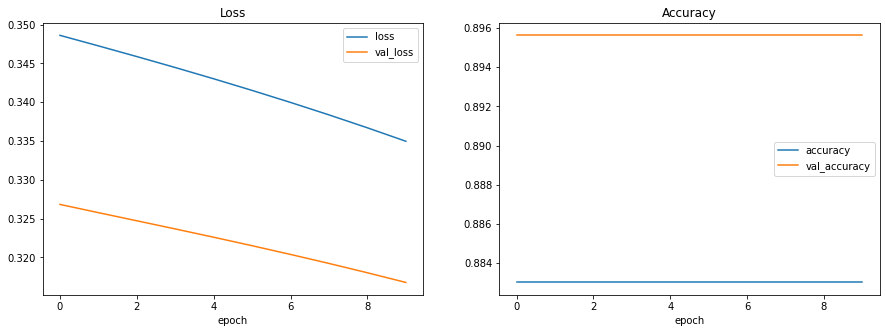

In [99]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].plot(history_model.history['loss'])
ax[0].plot(history_model.history['val_loss'])
ax[0].legend(['loss', 'val_loss'])
ax[0].set_title('Loss')
ax[0].set(xlabel='epoch')

ax[1].plot(history_model.history['accuracy'])
ax[1].plot(history_model.history['val_accuracy'])
ax[1].legend(['accuracy', 'val_accuracy'])
ax[1].set_title('Accuracy')
ax[1].set(xlabel='epoch')

plt.show()

In [100]:
FP = min(history_model.history['FalsePositives'])
FN = min(history_model.history['FalseNegatives'])
TN = min(history_model.history['TrueNegatives'])
TP = min(history_model.history['TruePositives'])
FAR = FN / (TP + FN)
FRR = FP / (FP + TN)
print('FAR: ', FAR * 100,'%')
print('FRR: ', FRR * 100, '%')

FAR:  11.698537319898605 %
FRR:  11.698537319898605 %
